# Transfer learning - Survival prediction
Here we are initializing the survival prediction task by using the pre-trained weights from the "foundation model" and fine tuning on survival prediction. We use for training 70% of the data and 30% for validation. 

This notebook guides you through the use of the clinical transformere API

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
tf.test.is_gpu_available()

tf.config.run_functions_eagerly(True)

tf.__version__
import sys
sys.path.append('../../../codeocean/environment/clinical_transformer/')

2025-08-14 20:04:10.847464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 20:04:10.903430: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 20:04:11.253629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-14 20:04:11.253662: W tensorflow/compiler/xla/stream_exe

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-14 20:04:11.660916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 20:04:11.696703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:04:11.713527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:04:11.713613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [2]:
from xai.models import Trainer
from xai.models import SurvivalTransformer
from xai.models import OptimizedSurvivalDataGenerator as SurvivalDataGenerator
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex_metric

In [3]:
import pandas as pd
from samecode.random import set_seed

## Dataset

In [4]:
data = pd.read_csv('./data/dataset-train.data.csv')
features = data.columns[-43:].tolist()
#features

## Parameters

In [5]:
max_features_percentile=100
test_size=0.1 # fraction of samples used for validation
repetitions=10 # number replicates (training / validation) random splits to evaluate variability.

mode='survival'
learning_rate=0.0001
epochs=300
verbose=1
seed=123
embedding_size = 128
num_heads = 2
num_layers = 8

In [6]:
! rm -r ./results/TransferLearningSurvival/

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)


## Training

In [7]:
outdir = './results/TransferLearningSurvival/'

set_seed(seed)

trainer = Trainer(
    from_pretrained='../FoundationModel/fold-0_id-0/model.E002000.h5',
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SurvivalTransformer, 
    dataloader=SurvivalDataGenerator,
    loss=cindex_loss,
    metrics=[cindex_metric]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
    target=['time', 'event']
)

trainer.setup_model(
    learning_rate=learning_rate,
    embedding_size=embedding_size,
    num_heads=num_heads,
    num_layers=num_layers,
    batch_size_max=True,
    save_best_only=False
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

/home/shenwanxiang/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO	2025-08-14 20:04:13,872	Setting up working directory: ./results/TransferLearningSurvival/
INFO	2025-08-14 20:04:13,872	Setting up transfer learning directory: ./results/TransferLearningSurvival//model.E002000.h5/
2025-08-14 20:04:13.875760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:04:13.875915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:04:13.875973: I tensorflow/compiler/xla/str

Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 20:04:15,411	AutoGraph could not transform <function cIndex_SigmoidApprox at 0x7f618d2e4680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 20:04:15,636	AutoGraph could not transform <function sigmoid_concordance at 0x7f613631e3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 532ms/step - loss: 0.4528 - sigmoid_concordance: 0.5677 - val_loss: 0.4412 - val_sigmoid_concordance: 0.6174
Epoch 2/300
1/1 [==============================] - 0s 304ms/step - loss: 0.4336 - sigmoid_concordance: 0.5961 - val_loss: 0.4248 - val_sigmoid_concordance: 0.6203
Epoch 3/300
1/1 [==============================] - 0s 293ms/step - loss: 0.4353 - sigmoid_concordance: 0.5836 - val_loss: 0.4113 - val_sigmoid_concordance: 0.6193
Epoch 4/300
1/1 [==============================] - 0s 293ms/step - loss: 0.4224 - sigmoid_concordance: 0.5963 - val_loss: 0.4013 - val_sigmoid_concordance: 0.6164
Epoch 5/300
1/1 [==============================] - 0s 297

INFO	2025-08-14 20:05:47,097	RUN ID: fold-1_id-1
INFO	2025-08-14 20:05:47,098	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-1_id-1/
INFO	2025-08-14 20:05:47,151	Training samples: 505
INFO	2025-08-14 20:05:47,151	Testing samples: 57
INFO	2025-08-14 20:05:47,153	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 458ms/step - loss: 0.4997 - sigmoid_concordance: 0.5041 - val_loss: 0.4668 - val_sigmoid_concordance: 0.6094
Epoch 2/300
1/1 [==============================] - 0s 298ms/step - loss: 0.4889 - sigmoid_concordance: 0.5223 - val_loss: 0.4258 - val_sigmoid_concordance: 0.6247
Epoch 3/300
1/1 [==============================] - 0s 297ms/step - loss: 0.4521 - sigmoid_concordance: 0.5754 - val_loss: 0.4003 - val_sigmoid_concordance: 0.6289
Epoch 4/300
1/1 [==============================] - 0s 296ms/step - loss: 0.4424 - sigmoid_concordance: 0.5795 - val_loss: 0.3992 - val_sigmoid_concordance: 0.6179
Epoch 5/300
1/1 [==============================] - 0s 294ms/step - loss: 0.4430 - sigmoid_concordance: 0.5743 - val_loss: 0.3984 - val_sigmoid_concordance: 0.6119
Epoch 6/300
1/1 [==============================] - 0s 300ms/step - loss: 0.4243 - sigmoid_concordance: 0.5912 - val_loss: 0.3977 - val_sigmoid_concordance: 0.6111
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:07:19,500	RUN ID: fold-2_id-2
INFO	2025-08-14 20:07:19,500	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-2_id-2/
INFO	2025-08-14 20:07:19,553	Training samples: 505
INFO	2025-08-14 20:07:19,553	Testing samples: 57
INFO	2025-08-14 20:07:19,555	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 461ms/step - loss: 0.5137 - sigmoid_concordance: 0.4722 - val_loss: 0.5029 - val_sigmoid_concordance: 0.4749
Epoch 2/300
1/1 [==============================] - 0s 312ms/step - loss: 0.4846 - sigmoid_concordance: 0.5324 - val_loss: 0.4994 - val_sigmoid_concordance: 0.4971
Epoch 3/300
1/1 [==============================] - 0s 296ms/step - loss: 0.4740 - sigmoid_concordance: 0.5406 - val_loss: 0.4952 - val_sigmoid_concordance: 0.5087
Epoch 4/300
1/1 [==============================] - 0s 296ms/step - loss: 0.4382 - sigmoid_concordance: 0.6032 - val_loss: 0.4911 - val_sigmoid_concordance: 0.5144
Epoch 5/300
1/1 [==============================] - 0s 297ms/step - loss: 0.4285 - sigmoid_concordance: 0.6075 - val_loss: 0.4872 - val_sigmoid_concordance: 0.5276
Epoch 6/300
1/1 [==============================] - 0s 297ms/step - loss: 0.4224 - sigmoid_concordance: 0.6075 - val_loss: 0.4833 - val_sigmoid_concordance: 0.5317
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:08:51,800	RUN ID: fold-3_id-3
INFO	2025-08-14 20:08:51,801	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-3_id-3/
INFO	2025-08-14 20:08:51,936	Training samples: 505
INFO	2025-08-14 20:08:51,936	Testing samples: 57
INFO	2025-08-14 20:08:51,937	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 475ms/step - loss: 0.4867 - sigmoid_concordance: 0.5316 - val_loss: 0.5003 - val_sigmoid_concordance: 0.5029
Epoch 2/300
1/1 [==============================] - 0s 301ms/step - loss: 0.5075 - sigmoid_concordance: 0.4882 - val_loss: 0.4646 - val_sigmoid_concordance: 0.6403
Epoch 3/300
1/1 [==============================] - 0s 295ms/step - loss: 0.4766 - sigmoid_concordance: 0.5402 - val_loss: 0.4317 - val_sigmoid_concordance: 0.7018
Epoch 4/300
1/1 [==============================] - 0s 300ms/step - loss: 0.4587 - sigmoid_concordance: 0.5609 - val_loss: 0.4010 - val_sigmoid_concordance: 0.7220
Epoch 5/300
1/1 [==============================] - 0s 295ms/step - loss: 0.4494 - sigmoid_concordance: 0.5738 - val_loss: 0.3746 - val_sigmoid_concordance: 0.7363
Epoch 6/300
1/1 [==============================] - 0s 297ms/step - loss: 0.4415 - sigmoid_concordance: 0.5807 - val_loss: 0.3502 - val_sigmoid_concordance: 0.7388
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:10:24,557	RUN ID: fold-4_id-4
INFO	2025-08-14 20:10:24,557	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-4_id-4/
INFO	2025-08-14 20:10:24,610	Training samples: 505
INFO	2025-08-14 20:10:24,610	Testing samples: 57
INFO	2025-08-14 20:10:24,612	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 465ms/step - loss: 0.5112 - sigmoid_concordance: 0.4754 - val_loss: 0.4836 - val_sigmoid_concordance: 0.5721
Epoch 2/300
1/1 [==============================] - 0s 306ms/step - loss: 0.5110 - sigmoid_concordance: 0.4740 - val_loss: 0.4699 - val_sigmoid_concordance: 0.5906
Epoch 3/300
1/1 [==============================] - 0s 315ms/step - loss: 0.4875 - sigmoid_concordance: 0.5230 - val_loss: 0.4563 - val_sigmoid_concordance: 0.6048
Epoch 4/300
1/1 [==============================] - 0s 305ms/step - loss: 0.4609 - sigmoid_concordance: 0.5665 - val_loss: 0.4423 - val_sigmoid_concordance: 0.6118
Epoch 5/300
1/1 [==============================] - 0s 302ms/step - loss: 0.4516 - sigmoid_concordance: 0.5787 - val_loss: 0.4287 - val_sigmoid_concordance: 0.6207
Epoch 6/300
1/1 [==============================] - 0s 300ms/step - loss: 0.4407 - sigmoid_concordance: 0.5861 - val_loss: 0.4161 - val_sigmoid_concordance: 0.6260
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:11:56,765	RUN ID: fold-5_id-5
INFO	2025-08-14 20:11:56,765	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-5_id-5/
INFO	2025-08-14 20:11:56,819	Training samples: 505
INFO	2025-08-14 20:11:56,819	Testing samples: 57
INFO	2025-08-14 20:11:56,820	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 470ms/step - loss: 0.5295 - sigmoid_concordance: 0.4564 - val_loss: 0.4966 - val_sigmoid_concordance: 0.5073
Epoch 2/300
1/1 [==============================] - 0s 298ms/step - loss: 0.5151 - sigmoid_concordance: 0.4744 - val_loss: 0.4900 - val_sigmoid_concordance: 0.5239
Epoch 3/300
1/1 [==============================] - 0s 390ms/step - loss: 0.4705 - sigmoid_concordance: 0.5516 - val_loss: 0.4866 - val_sigmoid_concordance: 0.5147
Epoch 4/300
1/1 [==============================] - 0s 325ms/step - loss: 0.4628 - sigmoid_concordance: 0.5622 - val_loss: 0.4866 - val_sigmoid_concordance: 0.4982
Epoch 5/300
1/1 [==============================] - 0s 304ms/step - loss: 0.4291 - sigmoid_concordance: 0.6057 - val_loss: 0.4874 - val_sigmoid_concordance: 0.4927
Epoch 6/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4354 - sigmoid_concordance: 0.5904 - val_loss: 0.4900 - val_sigmoid_concordance: 0.4936
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:13:29,773	RUN ID: fold-6_id-6
INFO	2025-08-14 20:13:29,773	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-6_id-6/
INFO	2025-08-14 20:13:29,826	Training samples: 505
INFO	2025-08-14 20:13:29,826	Testing samples: 57
INFO	2025-08-14 20:13:29,827	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 464ms/step - loss: 0.4992 - sigmoid_concordance: 0.5060 - val_loss: 0.4758 - val_sigmoid_concordance: 0.5842
Epoch 2/300
1/1 [==============================] - 0s 302ms/step - loss: 0.4614 - sigmoid_concordance: 0.5697 - val_loss: 0.4611 - val_sigmoid_concordance: 0.5940
Epoch 3/300
1/1 [==============================] - 0s 303ms/step - loss: 0.4517 - sigmoid_concordance: 0.5794 - val_loss: 0.4476 - val_sigmoid_concordance: 0.5957
Epoch 4/300
1/1 [==============================] - 0s 382ms/step - loss: 0.4270 - sigmoid_concordance: 0.6093 - val_loss: 0.4342 - val_sigmoid_concordance: 0.5949
Epoch 5/300
1/1 [==============================] - 0s 308ms/step - loss: 0.4322 - sigmoid_concordance: 0.5917 - val_loss: 0.4230 - val_sigmoid_concordance: 0.6011
Epoch 6/300
1/1 [==============================] - 0s 310ms/step - loss: 0.4273 - sigmoid_concordance: 0.5944 - val_loss: 0.4143 - val_sigmoid_concordance: 0.6055
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:15:02,867	RUN ID: fold-7_id-7
INFO	2025-08-14 20:15:02,867	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-7_id-7/
INFO	2025-08-14 20:15:02,921	Training samples: 505
INFO	2025-08-14 20:15:02,921	Testing samples: 57
INFO	2025-08-14 20:15:02,922	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 465ms/step - loss: 0.5064 - sigmoid_concordance: 0.4931 - val_loss: 0.4897 - val_sigmoid_concordance: 0.5957
Epoch 2/300
1/1 [==============================] - 0s 296ms/step - loss: 0.5100 - sigmoid_concordance: 0.4840 - val_loss: 0.4871 - val_sigmoid_concordance: 0.5714
Epoch 3/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4915 - sigmoid_concordance: 0.5121 - val_loss: 0.4860 - val_sigmoid_concordance: 0.5453
Epoch 4/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4663 - sigmoid_concordance: 0.5631 - val_loss: 0.4847 - val_sigmoid_concordance: 0.5369
Epoch 5/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4435 - sigmoid_concordance: 0.5885 - val_loss: 0.4833 - val_sigmoid_concordance: 0.5294
Epoch 6/300
1/1 [==============================] - 0s 301ms/step - loss: 0.4351 - sigmoid_concordance: 0.5927 - val_loss: 0.4816 - val_sigmoid_concordance: 0.5294
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:16:35,620	RUN ID: fold-8_id-8
INFO	2025-08-14 20:16:35,620	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-8_id-8/
INFO	2025-08-14 20:16:35,674	Training samples: 505
INFO	2025-08-14 20:16:35,674	Testing samples: 57
INFO	2025-08-14 20:16:35,675	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 460ms/step - loss: 0.5144 - sigmoid_concordance: 0.4791 - val_loss: 0.4789 - val_sigmoid_concordance: 0.6009
Epoch 2/300
1/1 [==============================] - 0s 299ms/step - loss: 0.5071 - sigmoid_concordance: 0.4879 - val_loss: 0.4675 - val_sigmoid_concordance: 0.6181
Epoch 3/300
1/1 [==============================] - 0s 296ms/step - loss: 0.4806 - sigmoid_concordance: 0.5355 - val_loss: 0.4560 - val_sigmoid_concordance: 0.6299
Epoch 4/300
1/1 [==============================] - 0s 297ms/step - loss: 0.4639 - sigmoid_concordance: 0.5597 - val_loss: 0.4461 - val_sigmoid_concordance: 0.6190
Epoch 5/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4511 - sigmoid_concordance: 0.5756 - val_loss: 0.4372 - val_sigmoid_concordance: 0.6136
Epoch 6/300
1/1 [==============================] - 0s 300ms/step - loss: 0.4398 - sigmoid_concordance: 0.5850 - val_loss: 0.4283 - val_sigmoid_concordance: 0.6081
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:18:08,023	RUN ID: fold-9_id-9
INFO	2025-08-14 20:18:08,023	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-9_id-9/
INFO	2025-08-14 20:18:08,076	Training samples: 505
INFO	2025-08-14 20:18:08,076	Testing samples: 57
INFO	2025-08-14 20:18:08,077	Number of features at 100th percentile: 43 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 460ms/step - loss: 0.5234 - sigmoid_concordance: 0.4603 - val_loss: 0.4954 - val_sigmoid_concordance: 0.5251
Epoch 2/300
1/1 [==============================] - 0s 305ms/step - loss: 0.5054 - sigmoid_concordance: 0.4895 - val_loss: 0.4779 - val_sigmoid_concordance: 0.5968
Epoch 3/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4876 - sigmoid_concordance: 0.5243 - val_loss: 0.4624 - val_sigmoid_concordance: 0.6138
Epoch 4/300
1/1 [==============================] - 0s 296ms/step - loss: 0.4390 - sigmoid_concordance: 0.6027 - val_loss: 0.4493 - val_sigmoid_concordance: 0.6048
Epoch 5/300
1/1 [==============================] - 0s 299ms/step - loss: 0.4417 - sigmoid_concordance: 0.5843 - val_loss: 0.4385 - val_sigmoid_concordance: 0.6013
Epoch 6/300
1/1 [==============================] - 0s 312ms/step - loss: 0.4342 - sigmoid_concordance: 0.5887 - val_loss: 0.4300 - val_sigmoid_concordance: 0.5968
Epoch 7/300
1/1 [=================

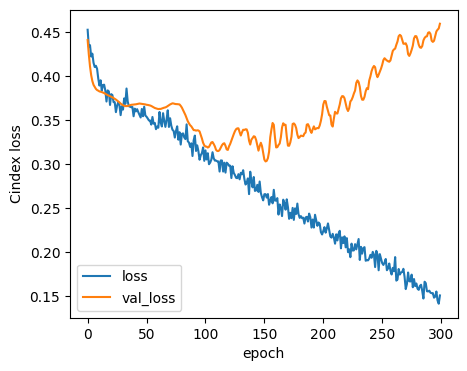

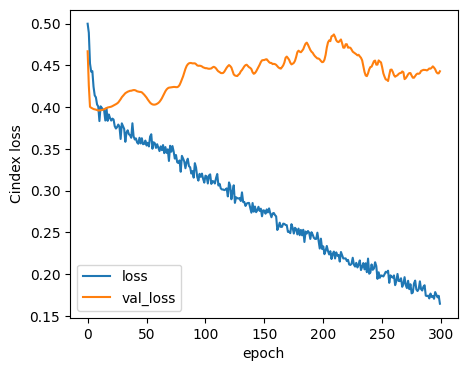

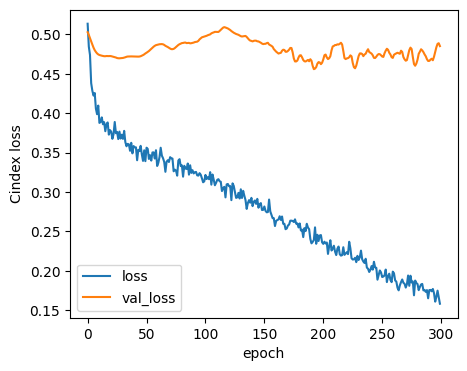

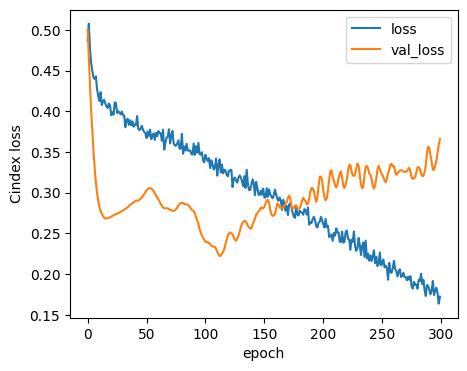

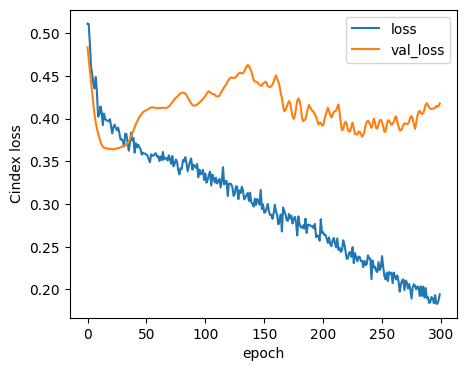

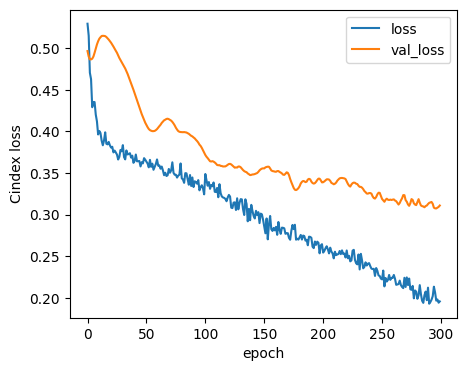

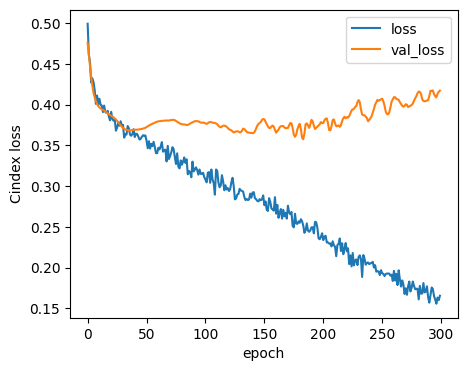

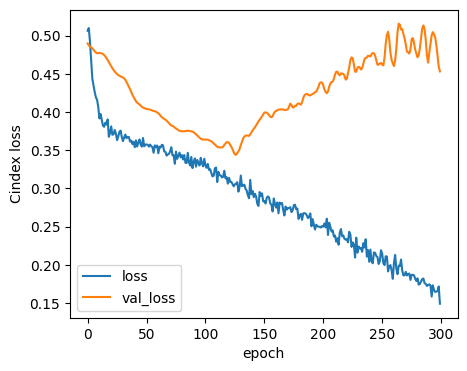

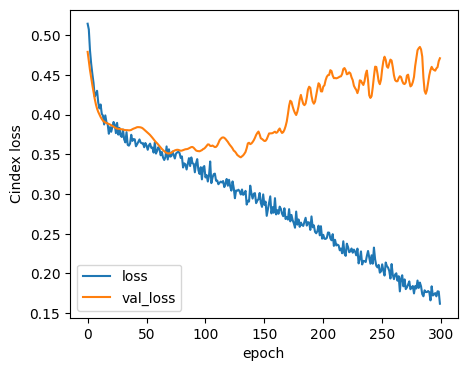

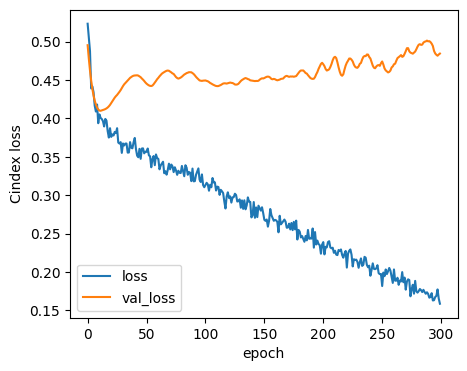

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
best_es = []
for i in range(repetitions):
    dfh = pd.read_csv("./results/TransferLearningSurvival/model.E002000.h5/fold-%s_id-%s/history.csv" % (i,i), index_col=0)
    fig, ax=plt.subplots(figsize=(5,4))
    dfh[['loss', 'val_loss']].plot(ax=ax)
    ax.set_ylabel('Cindex loss')

    best_es.append(dfh.val_sigmoid_concordance)

best_epoch = pd.concat(best_es, axis=1).mean(axis=1).idxmax()

In [11]:
best_epoch

111

In [10]:
data

,time,event,cohort,ICI_target,ICI,cancer_type,response_label,TMB,Bcell_general,Memory_Bcell,...,Pancreatic,Pneumocyte,Apoptosis_pathway,IFNg_pathway,TGFb_pathway,Cytokine,Cell_proliferation,TLS,Genome_integrity,Reference
0,2.266667,1.0,Rose,PD-L1,Durvalumab,BLCA,NR,7.0,-0.454394,-0.406157,...,-0.299234,-0.340050,0.365382,-0.217105,0.859464,-0.674270,0.066695,-0.145004,0.271004,0.982282
1,10.766667,0.0,Rose,PD1,Pembrolizumab,BLCA,NR,4.4,-0.211316,-0.333523,...,-0.345650,-0.181527,0.370887,0.086027,0.891529,-0.427105,-0.034297,0.207211,0.334914,1.046119
2,16.200000,0.0,Rose,PD-L1,Atezolizumab,BLCA,NR,9.8,-0.168210,-0.300495,...,-0.295894,-0.318489,0.406458,-0.111525,0.904573,-0.482824,0.017364,0.085447,0.165408,1.050952
3,19.466667,0.0,Rose,PD-L1,Atezolizumab,BLCA,R,6.1,-0.305829,-0.117590,...,-0.590066,-0.300616,0.398682,0.334601,0.874000,-0.374289,0.369715,0.053431,0.654379,1.133018
4,1.533333,1.0,Rose,PD1,Nivolumab,BLCA,NR,5.2,-0.000527,-0.019245,...,-0.233568,-0.317578,0.468428,-0.195219,0.706146,-0.619811,-0.191942,-0.049493,0.058977,0.998960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,16.400000,1.0,MGH,PD1,unknow,SKCM,R,32.0,-0.266161,-0.255296,...,-0.581683,-0.245451,-0.153487,0.114295,0.323784,-0.732771,0.308553,0.039423,0.554524,1.169524
558,41.833333,1.0,MGH,PD1,unknow,SKCM,R,NaN,-0.458309,-0.444623,...,-0.486308,-0.285343,0.082426,-0.246982,0.498618,-0.730050,0.242296,-0.238452,0.433632,1.231082
559,53.600000,0.0,MGH,PD1,unknow,SKCM,R,617.0,-0.397320,-0.274468,...,-0.663239,-0.265541,0.120649,0.204441,0.319932,-0.689876,0.236759,-0.108548,0.332934,1.175981
560,14.166667,1.0,MGH,PD1+KIR,unknow,SKCM,R,NaN,0.117251,0.096816,...,-0.381528,-0.346936,0.194342,0.357155,0.352809,-0.559134,0.261466,0.094803,0.439915,1.193022
